In [23]:
#two models: one uptrend and second downtrend 
# => indentify 3 classes: strong uptrend, sideways, strong downtrend

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import seaborn as sns; sns.set(style='whitegrid')
sns.set_context(context='paper',font_scale=1.5)

import torch
import torch.nn as nn
from torch.autograd import Variable

from scipy.signal import savgol_filter as smooth

from pytorchtools import EarlyStopping

#save model
from sklearn.externals import joblib 

#metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, \
                            recall_score, f1_score, accuracy_score

#custom functions
import utilities as util

#clean
import gc; gc.enable()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [33]:
def sliding_windows(data, seq_length, shift = 0):
    x = []
    y = []

    for i in range(len(data) - seq_length - shift):
        _x = data[i:(i + seq_length)]
        _y = data[i + seq_length + shift]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

#for cross-validation
def sliding_windows_x(data, tot_length, train_size_pct = 0.8):
    x = []
    seq_length = int(tot_length * train_size_pct)
    out_length = tot_length - seq_length
    
    for i in range(0,len(data) - seq_length, out_length):
        _x =data[i:(i + seq_length)]
        x.append(_x)

    return np.array(x)

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)         
        self.sg = nn.Sigmoid()   

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, c_out) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out  = self.fc(h_out)
        probs = self.sg(out)
        
        return probs
    
    
def train_lstm(df, seq_length, patience, window, hidden_size,
               class_up, num_epochs = 3000, train_size_pct = 0.8, optimize = 1, cv = 0):
    """Function that trains LSTM model"""
    
    #add column with smoothed original price data
    df[f'smooth_y_w{window}'] = smooth(df['y'].values, 2*window+1, 3)

    signal = 'buy' if class_up == 1 else 'sell'
    used_cols = [f'smooth_y_w{window}',f'Predict_{signal}_prob']

    # generate training and target data
    training_data = df[used_cols].values.reshape(-1, 2)
    target = df[f'TARGET_{signal}'].values.reshape(-1, 1)

    learning_rate = 0.1
    momentum = 0.9

    input_size = 2
    #hidden_size = 4
    num_layers = 1
    num_classes = 1

    x, y_ = sliding_windows(training_data, seq_length)
    x_, y = sliding_windows(target, seq_length)
    
    del x_, y_
    gc.collect;

    #train-test split
    train_size = int(len(y) * train_size_pct)
    test_size = len(y) - train_size
    
    signal = 'uptrend' if class_up == 1 else 'downtrend'
    print(f'Train size is {train_size}, test size is {test_size} for {signal}.')

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)).reshape(-1,num_classes))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size]).reshape(-1,num_classes)))

    testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size:len(y)]).reshape(-1,num_classes)))

    lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate, momentum=momentum)

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    #save model to this file
    add = f'_cv{cv}' if cv > 0 else ''
    f_name = f'LSTM_trained_class/lstm_input{seq_length}_h{hidden_size}_w{window}_class{class_up}_p{patience}{add}.pkl'
    
    print(f_name)
    
    train_losses = []
    valid_losses = []
    
    if optimize == 1:
    
        # Train the model
        for epoch in range(num_epochs):
            probs = lstm(trainX)
            optimizer.zero_grad()

            # obtain the loss function
            loss = criterion(probs, trainY)    
            loss.backward()

            #optimize
            optimizer.step()
            train_loss = loss.item()
            train_losses.append(train_loss)

            # validate the model
            lstm.eval() 
            #calculate probs of train set
            probs = lstm(testX)
            # obtain the loss function
            loss = criterion(probs, testY) 
            # record validation loss
            valid_loss = loss.item()
            valid_losses.append(valid_loss)

            if epoch % 100 == 0:
                #print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
                print("Epoch: %d, " % (epoch) + 
                       f' train_loss: {train_loss:.5f} ' +
                       f' valid_loss: {valid_loss:.5f}')

            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            early_stopping(valid_loss, lstm)

            if early_stopping.early_stop:
                print("Early stopping")
                break

        #saving the model
        joblib.dump(lstm, f_name) 
    else:
        lstm = joblib.load(f_name)
    
    return lstm, dataX, dataY, train_size, train_losses, valid_losses


def plot_roc(dataY_plot, data_predict, train_size, class_up, figsize = (8,4)):
    #test roc curve
    fpr_test, tpr_test, _ = roc_curve(dataY_plot[train_size:], data_predict[train_size:])
    roc_auc_test = auc(fpr_test, tpr_test)

    #train roc curve
    fpr_train, tpr_train, _ = roc_curve(dataY_plot[:train_size], data_predict[:train_size])
    roc_auc_train = auc(fpr_train, tpr_train)
    
    #plot
    fig = plt.figure(figsize=figsize)
    plt.plot(fpr_test, tpr_test, color='darkgreen',
             lw=2, label='Test AUC = %0.3f'%roc_auc_test)
    plt.plot(fpr_train, tpr_train, color='red',
             lw=2, label='Train AUC = %0.3f'%roc_auc_train)
    
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0]), plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    signal = 'uptrend' if class_up == 1 else 'downtrend'
    plt.title(f'Receiver operating characteristic for {signal}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
    return fig, roc_auc_train, roc_auc_test

def plot_cm(y_test, y_pred, ticklabels, cmap, figsize, save_pref):
    fig1, (ax1,ax2) = plt.subplots(1,2,figsize=figsize)

    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap((cm.T / cm.sum(axis=1)).T,annot=True,cmap=cmap,ax=ax1)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Target')
    ax1.set_xticklabels(ticklabels)
    ax1.set_yticklabels(ticklabels)
    ax1.set_title('Recall')

    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap((cm / cm.sum(axis=0)),annot=True,cmap=cmap,ax=ax2)
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Target')
    ax2.set_xticklabels(ticklabels)
    ax2.set_yticklabels(ticklabels)
    ax2.set_title('Precision')
    plt.tight_layout()
    path = 'LSTM_trained_class/figs'
    fig1.savefig(f'{path}/cm_recall_presicion{save_pref}.png')
    plt.show()

    #calssification report
    print(classification_report(y_test, y_pred))

    fig2, ax = plt.subplots(1,1,figsize=(6,4))
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm/cm.sum(),annot=True,cmap=cmap,ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Target')
    ax.set_xticklabels(ticklabels)
    ax.set_yticklabels(ticklabels)
    ax.set_title('Confusion matrix')
    fig2.savefig(f'{path}/cm{save_pref}.png')
    plt.tight_layout()
    plt.show()
    
    #change the probability threshold
def vary_prob_trh(prob_th_1, prob_th_0, 
                  data_predict_1, data_predict_0, 
                  train_size, target, target_pred):
    
    df, _, _, _ = read_data()

    #predictions for uptrend accounting for input length
    df['lstm_up'] = (np.concatenate((np.zeros(seq_length_1),
                                     data_predict_1.reshape(-1)),axis=0)
                                     > prob_th_1).astype('int')
    #predictions for downtrend accounting for input length
    df['lstm_down'] = (np.concatenate((np.zeros(seq_length_0),
                                     data_predict_0.reshape(-1)),axis=0)
                                     > prob_th_0).astype('int')

    #combine two models for overall trend
    df['lstm_trend'] = df.lstm_up - df.lstm_down
    df['TARGET_trend'] = df.TARGET_buy - df.TARGET_sell

    ##cut data without predictions
    df = df.iloc[max(seq_length_0,seq_length_1):,:]
    #select test data
    df = df.iloc[train_size:,:]
    df.set_index('Date',inplace=True)
    
    r = recall_score(df[target], df[target_pred])
    p = precision_score(df[target], df[target_pred])
    f1 = f1_score(df[target], df[target_pred])
    
    return r, p, f1

def get_value(df_input,buy_list,sell_list):
    
    df = df_input.copy()
    starting_shares = 10

    df['Shares'] = 0
    df['Bankroll'] = 0
    df['Action'] = 0    # Buy=-1 / Sell=+1

    #buy_list = df.Date[min_list].tolist()
    #sell_list = df.Date[max_list].tolist()

    df.loc[buy_list, 'Action'] = -1
    df.loc[sell_list, 'Action'] = 1

    t0 = df.Date[0]

    df.loc[t0, 'Shares'] = starting_shares

    for i, t in enumerate(df.Date.tolist()):
        action = df.loc[t, 'Action']

        # update
        if i >= 1:
            t_prev = df.Date[i-1]
            n_prev = df.loc[t_prev, 'Shares']
            usd_prev = df.loc[t_prev, 'Bankroll']
            df.loc[t, 'Shares'] = n_prev
            df.loc[t, 'Bankroll'] = usd_prev

        if action == 1: 
            # Sell
            bankroll = df['Bankroll'][i]
            n_shares = df['Shares'][i]
            price = df['Close'][i]

            bankroll = bankroll + n_shares*price
            df.loc[t, 'Bankroll'] = bankroll
            df.loc[t, 'Shares'] = 0

        elif action == -1:
            # Buy
            bankroll = df['Bankroll'][i]
            n_shares = df['Shares'][i]
            price = df['Close'][i]

            n_shares = n_shares + bankroll/price
            df.loc[t, 'Bankroll'] = 0
            df.loc[t, 'Shares'] = n_shares

        gc.collect()

    df['Value'] = df['Close']*df['Shares'] + df['Bankroll']
    df['Baseline'] = starting_shares*df['Close']
    
    return df

def read_data():
    
    #load weekly data
    df = pd.read_csv('datahub/wti-week_csv.csv',index_col='Date',parse_dates=True)
    #step = 1 week = 5 days
    df.reset_index(inplace=True)
    #time range:
    #print('Time range: ', df.Date.min(), df.Date.max())
    df.head()

    #log transform and level the data
    #log transform
    df['log_price'] = np.log(df.Price/df.Price.iloc[0])

    #remove trend by fitting 
    m, b = util.ols(df['log_price'])
    ref = df.Price.iloc[0]
    #leveled_log_price
    df['y'] = df['log_price'] - (b + df.index * m)
    
    df.drop(columns = ['log_price'], inplace = True)

    #print(f'Transformation: normalize by initial value {ref}\
    #and shifted/leveled by a line with m={round(m,5)}, b={round(b,3)}.')

    df_buy = pd.read_csv(f'datahub/buy_target.csv',
                         index_col='Date',parse_dates=True).reset_index()\
                         .rename(columns={'TARGET':'TARGET_buy'})
    df_sell = pd.read_csv(f'datahub/sell_target.csv',
                          index_col='Date',parse_dates=True).reset_index()\
                         .rename(columns={'TARGET':'TARGET_sell'})

    #t.Date=pd.to_datetime(t.Date)
    df = df.merge(df_buy,on='Date')[['Date','Price','y',
                                     'Predict_buy_prob','TARGET_buy']]

    df = df.merge(df_sell,on='Date')[['Date','Close','y',
                                      'Predict_buy_prob','TARGET_buy',
                                      'Predict_sell_prob','TARGET_sell']]

    return df, m, b, ref

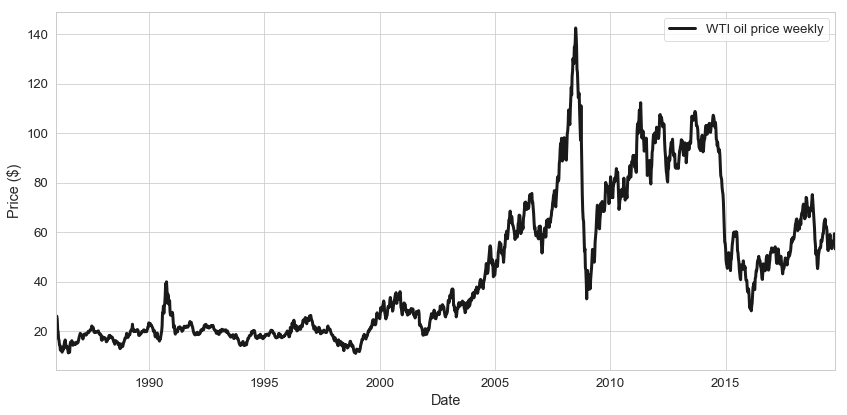

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 1986-01-03 to 2019-10-04
Data columns (total 1 columns):
Price    1762 non-null float64
dtypes: float64(1)
memory usage: 27.5 KB


In [34]:
####original data#####
df_week = pd.read_csv('datahub/wti-week_csv.csv',index_col='Date',parse_dates=True)
#plot original target
fig, ax = plt.subplots(1,1,figsize=(12,6))

df_week.Price.plot(color='k', ax = ax, lw=3, label = "WTI oil price weekly")
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend()
plt.tight_layout()
plt.show()

path = 'LSTM_trained_class/figs'
fig.savefig(f'{path}/original_data_week.png')

df_week.info()

In [35]:
#how many years of data do we have?
print(f'There are {round((df_week.index.max() - \
                   df_week.index.min()).days / 365.25,1)} years.')

There are 33.7 years.


In [36]:
##############################
##########read data###########
##############################
df, _, _, _ = read_data()
df.head()

,Date,Close,y,Predict_buy_prob,TARGET_buy,Predict_sell_prob,TARGET_sell
0,1989-10-27,19.65,0.133591,0.500126,1,0.374930,0
1,1989-11-03,19.99,0.149680,0.187179,1,0.312533,0
2,1989-11-10,19.89,0.143599,0.479687,1,0.285054,0
3,1989-11-17,19.74,0.134963,0.728498,1,0.108064,0
4,1989-11-24,20.02,0.147981,0.579599,0,0.227502,0


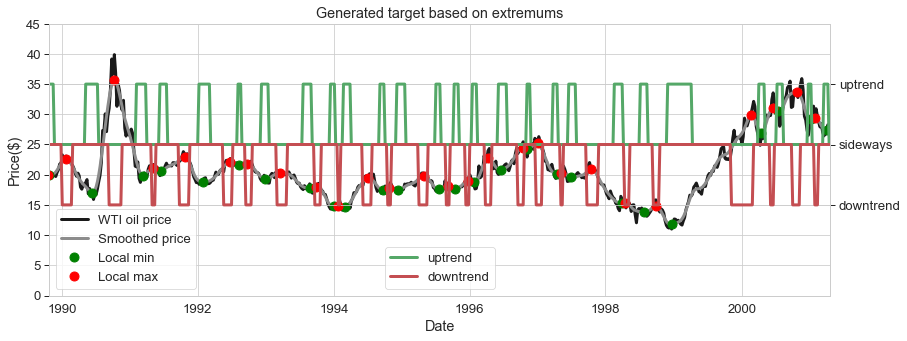

In [37]:
#plot generated target
df_max = pd.read_csv('datahub/max_data.csv',index_col='t',parse_dates=True)
df_min = pd.read_csv('datahub/min_data.csv',index_col='t',parse_dates=True)
df_smooth = pd.read_csv('datahub/smooth_data.csv',index_col='Date',parse_dates=True)
df_buy = pd.read_csv('datahub/buy_target.csv',index_col='Date',parse_dates=True)
df_sell = pd.read_csv('datahub/sell_target.csv',index_col='Date',parse_dates=True)

cut = 600

fig, ax = plt.subplots(1,1,figsize=(14,5))

df_buy.Close.plot(lw=3,ax=ax,label="WTI oil price",color='k')
df_smooth.plot(lw=3,ax=ax,label='Smoothed price',color=sns.color_palette()[7]) 

df_min.plot(marker='o', markersize=9, lw=0, color="green",ax=ax,label='Local min')
df_max.plot(marker='o', markersize=9, lw=0, color="red",ax=ax,label='Local max')

ax.set_xlabel('Date')
ax.set_ylabel('Price($)')
ax.legend(('WTI oil price','Smoothed price','Local min', 'Local max'))

ax2 = ax.twinx()
df_buy['TARGET'].plot(lw=3,ax=ax2,label='uptrend',
                            color=sns.color_palette()[2],legend=True)

(df_sell['TARGET'].apply(lambda x: 0 if x == 1 else 1) - 1)\
                 .plot(lw=3,ax=ax2,label='downtrend',
                       color=sns.color_palette()[3],legend=True)

ax2.set_ylim(-2.5,2)
ax2.set_yticks([-1, 0,1])
ax2.set_yticklabels(['downtrend','sideways','uptrend'])
ax2.legend(loc='lower center')

ax.set_xlim(df_buy.index[0],df_buy.index[cut])
ax.set_ylim(0,45)
ax.set_title('Generated target based on extremums')

plt.show()

path = 'LSTM_trained_class/figs'
fig.savefig(f'{path}/generate_target.png')

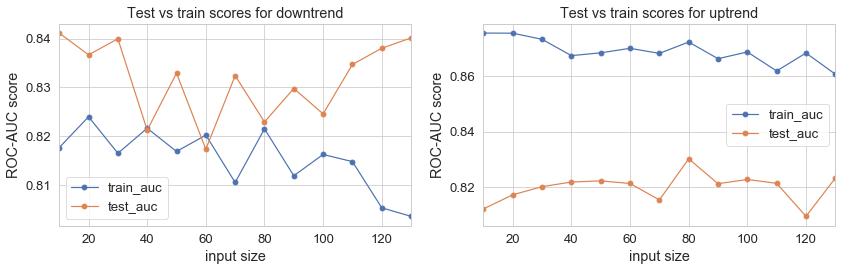

In [38]:
#optimizing input sequence length

#test-auc vs seq_length
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

class_up = 0
path = 'LSTM_trained_class/models'
df_results = pd.read_csv(f'{path}/summary_h4_class{class_up}.csv',index_col=False)
df_results.set_index('seq_length').plot(marker='o', ax=ax1)
#plt.axvline(80,0,1)
ax1.set_xlabel('input size')
ax1.set_ylabel('ROC-AUC score')
ax1.set_title(f'Test vs train scores for downtrend')

class_up = 1
path = 'LSTM_trained_class/models'
df_results = pd.read_csv(f'{path}/summary_h4_class{class_up}.csv',index_col=False)
df_results.set_index('seq_length').plot(marker='o', ax=ax2)
#plt.axvline(80,0,1)
ax2.set_xlabel('input size')
ax2.set_ylabel('ROC-AUC score')
ax2.set_title(f'Test vs train scores for uptrend')

plt.tight_layout()
plt.show()

#select input sequence size corresponding to maximum test_auc score
#10 weeks for downtrend and 80 weeks for uptrend (class_up=1)

10-fold cross-validation
Train size is 305, test size is 77 for uptrend.
LSTM_trained_class/lstm_input80_h4_w7_class1_p30.pkl


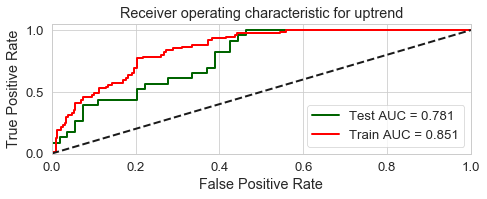

10-fold cross-validation
Train size is 305, test size is 77 for uptrend.
LSTM_trained_class/lstm_input80_h4_w7_class1_p30_cv1.pkl


FileNotFoundError: [Errno 2] No such file or directory: 'LSTM_trained_class/lstm_input80_h4_w7_class1_p30_cv1.pkl'

In [39]:
#Do slide-window cross-validation
##############################
######input parameters########
##############################
#select smoothing window for target
window = 7
#select signal type: buy or sell
class_up = 1 #0
#input sequence length
seq_length = 80 #10
#early stopping patience to avoid overfitting
patience = 30
num_epochs = 1000

#if optimize = 1 model will be trained, otherwise reads existing results
optimize = 0

#LSTM parameters
hidden_size = 4
##############################
##############################
##############################

#seq_lengths = range(5,16,1)
train_auc_scores = []
test_auc_scores = []

#implement cross-validation cv = 11
df_inds = sliding_windows_x(np.arange(0,df.shape[0]), 
                            tot_length=int(df.shape[0]/2.7)) #1.8 for cv = 5, 2.7 for cv = 10

for cv in range(len(df_inds)):
    
    print(f'{len(df_inds)}-fold cross-validation')

    lstm, dataX, dataY, train_size, train_losses, valid_losses = \
                                                train_lstm(df.loc[df_inds[cv],:], 
                                                seq_length, patience, window, 
                                                hidden_size, class_up, cv = cv, optimize = optimize)

    #predict for buy signal
    data_predict = lstm(dataX).data.numpy()
    #original target
    dataY_plot = dataY.data.numpy()

    fig, roc_auc_train, roc_auc_test = plot_roc(dataY_plot, data_predict, train_size,
                                                  class_up, figsize = (7,3))
    train_auc_scores.append(roc_auc_train)
    test_auc_scores.append(roc_auc_test)
    
    
    if optimize == 1:
        #plot early stopping train vs valid lossess
        plt.plot(train_losses,color='r',label='train')
        plt.plot(valid_losses,color='g',label='test')
        plt.legend()
        plt.xlabel('num_epochs')
        plt.ylabel('losess')
        plt.title('Train vs test losses for class=1')
        plt.show()
        print(f'Done with seq_length={seq_length}')

if optimize == 1:
    #write results
    df_results = pd.DataFrame({'cv':cv,
                           'train_auc':train_auc_scores,
                           'test_auc': test_auc_scores})
    
    df_results.to_csv(f'LSTM_trained_class/final/summary_seq{seq_length}_h{hidden_size}_class{class_up}_cv{cv}.csv',
                 index=False)
    

In [20]:
#5-fold cross-validation for class 1
path = 'LSTM_trained_class/final_models_cv'
df_results = pd.read_csv(f'{path}/summary_seq80_h4_class1_cv4.csv',index_col=False)
df_results[['train_auc','test_auc']].apply(['mean','std']).round(3)

,train_auc,test_auc
mean,0.863,0.911
std,0.025,0.039


In [10]:
#10-fold cross-validation for class 1
df_results = pd.read_csv(f'{path}/summary_seq80_h4_class1_cv9.csv',index_col=False)
df_results[['train_auc','test_auc']].apply(['mean','std']).round(3)

,train_auc,test_auc
mean,0.855,0.832
std,0.051,0.084


In [11]:
#5-fold cross-validation for class 0, seq = 10
df_results = pd.read_csv(f'{path}/summary_seq10_h4_class0_cv4.csv',index_col=False)
df_results[['train_auc','test_auc']].apply(['mean','std']).round(3)

,train_auc,test_auc
mean,0.813,0.832
std,0.027,0.067


In [21]:
#10-fold cross-validation for class 0, seq = 10
df_results = pd.read_csv(f'{path}/summary_seq10_h4_class0_cv9.csv',index_col=False)
df_results[['train_auc','test_auc']].apply(['mean','std']).round(3)

,train_auc,test_auc
mean,0.825,0.825
std,0.039,0.084


Train size is 1186, test size is 297 for uptrend.
LSTM_trained_class/lstm_input80_h4_w7_class1_p30.pkl
Train size is 1242, test size is 311 for downtrend.
LSTM_trained_class/lstm_input10_h4_w7_class0_p30.pkl


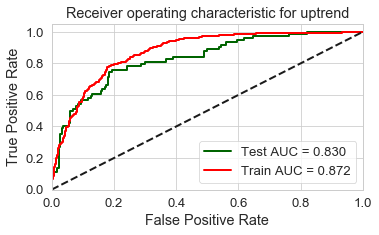

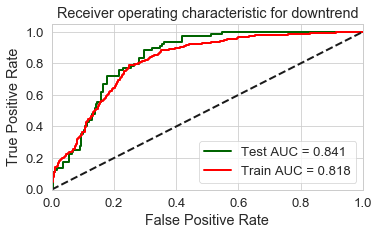

In [40]:
#plot results for the selected model

df, _, _, _ = read_data()

seq_length_1 = 80
seq_length_0 = 10

#uptrend
lstm_1, dataX_1, dataY_1, train_size_1, _, _ = train_lstm(df, 
                                                  seq_length=seq_length_1, patience=30, window=7, 
                                                  hidden_size=4, class_up=1, optimize=0)
#downtrend
lstm_0, dataX_0, dataY_0,train_size_0, _, _ = train_lstm(df, 
                                                seq_length=seq_length_0, patience=30, window=7, 
                                                hidden_size=4, class_up=0, optimize=0)

#predictions for uptrend
data_predict_1 = lstm_1(dataX_1).data.numpy()
dataY_plot_1 = dataY_1.data.numpy()

#predictions for downtrend
data_predict_0 = lstm_0(dataX_0).data.numpy()
dataY_plot_0 = dataY_0.data.numpy()

fig_1, _, _ = plot_roc(dataY_plot_1, data_predict_1, train_size_1, 
                       class_up = 1, figsize = (5.5,3.5))
fig_0, _, _  = plot_roc(dataY_plot_0, data_predict_0, train_size_0, 
                        class_up = 0, figsize = (5.5,3.5))

path = 'LSTM_trained_class/figs'
fig_1.savefig(f'{path}/roc_auc_up.png')
fig_0.savefig(f'{path}/roc_auc_down.png')

train_size = max(train_size_1, train_size_0)

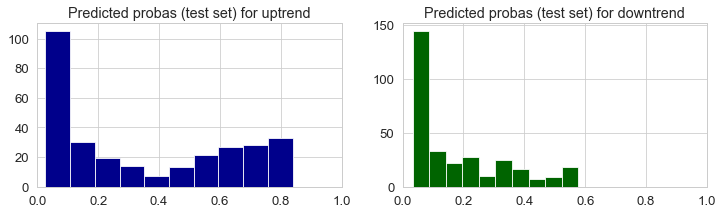

In [41]:
#plot predicted probabilities by LSTM for test data
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,3))

ax1.hist(data_predict_1[train_size_1:],label='up',color='darkblue'),
ax1.set_title('Predicted probas (test set) for uptrend')
ax1.set_xlim(0,1)

ax2.hist(data_predict_0[train_size_0:],label='down',color='darkgreen')
ax2.set_title('Predicted probas (test set) for downtrend')
ax2.set_xlim(0,1)
plt.show()

Best f1-score with prob_threshold for uptrend = 0.56


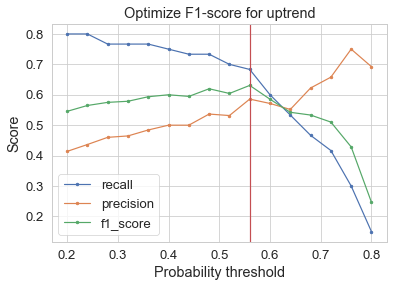

In [42]:
# Choose the probability threshold by maximazing F1-score
#For uptrend
_recall = []
_precision = []
_f1 = []
probs = np.linspace(0.2,0.8,16)

for pr in probs:
    r, p, f1 = vary_prob_trh(pr, 0.3, data_predict_1, 
                             data_predict_0,train_size,
                             target='TARGET_buy',target_pred='lstm_up')
    _recall.append(r)
    _precision.append(p)
    _f1.append(f1)

plt.plot(probs,_recall,label='recall',marker='.')
plt.plot(probs,_precision,label='precision',marker='.')
plt.plot(probs,_f1,label='f1_score',marker='.')
plt.legend()
plt.axvline(probs[np.argmax(_f1)],0,1,color='r')
plt.title('Optimize F1-score for uptrend')
plt.xlabel('Probability threshold')
plt.ylabel('Score')

prob_th_1 = probs[np.argmax(_f1)]
print(f'Best f1-score with prob_threshold for uptrend = {probs[np.argmax(_f1)]}')

Best f1-score with prob_threshold for downtrend = 0.24000000000000002


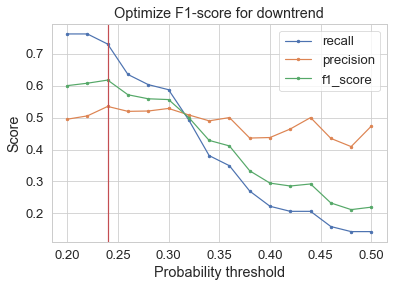

In [43]:
_recall = []
_precision = []
_f1 = []
probs = np.linspace(0.2,0.5,16)

for pr in probs:
    r, p, f1 = vary_prob_trh(0.54, pr, data_predict_1, 
                             data_predict_0,train_size,
                             target='TARGET_sell',target_pred='lstm_down')
    _recall.append(r)
    _precision.append(p)
    _f1.append(f1)

plt.plot(probs,_recall,label='recall',marker='.')
plt.plot(probs,_precision,label='precision',marker='.')
plt.plot(probs,_f1,label='f1_score',marker='.')
plt.legend()
plt.axvline(probs[np.argmax(_f1)],0,1,color='r')
plt.title('Optimize F1-score for downtrend')
plt.xlabel('Probability threshold')
plt.ylabel('Score')

prob_th_0 = probs[np.argmax(_f1)]
print(f'Best f1-score with prob_threshold for downtrend = {probs[np.argmax(_f1)]}')

In [44]:
#define prob treshholds for uptrend and downtrend
#prob_th_1 = np.mean([data_predict_1.max(), data_predict_1.min()]) #0.5
#prob_th_0 = np.mean([data_predict_0.max(), data_predict_0.min()]) #0.5
#prob_th_1 = 0.7
#prob_th_0 = 0.45

print(f'Probability threshold for trend up = {prob_th_1:.3f}, down = {prob_th_0:.3f}')

df, _, _, _ = read_data()

#predictions for uptrend accounting for input length
df['lstm_up'] = (np.concatenate((np.zeros(seq_length_1),
                                 data_predict_1.reshape(-1)),axis=0)
                                 > prob_th_1).astype('int')
#predictions for downtrend accounting for input length
df['lstm_down'] = (np.concatenate((np.zeros(seq_length_0),
                                 data_predict_0.reshape(-1)),axis=0)
                                 > prob_th_0).astype('int')

#combine two models for overall trend
df['lstm_trend'] = df.lstm_up - df.lstm_down
df['TARGET_trend'] = df.TARGET_buy - df.TARGET_sell

#check for simultaneous buy and sell signal
print(f"There is {(df.lstm_up*df.lstm_down).sum()} overlap between predicted buy/sell")
print(f"There is {(df.TARGET_buy*df.TARGET_sell).sum()} overlap between target buy/sell")

df.head()
end_train_date = df.iloc[max(train_size_1,train_size_0),0]
print(f'Train-test boundary is {str(end_train_date)}')

#cut df for plotting
df = df.iloc[max(seq_length_0,seq_length_1):,:]
df.set_index('Date',inplace=True)
end_train_ind = max(train_size_1,train_size_0) - max(seq_length_0,seq_length_1)

Probability threshold for trend up = 0.560, down = 0.240
There is 0 overlap between predicted buy/sell
There is 0 overlap between target buy/sell
Train-test boundary is 2013-08-16 00:00:00


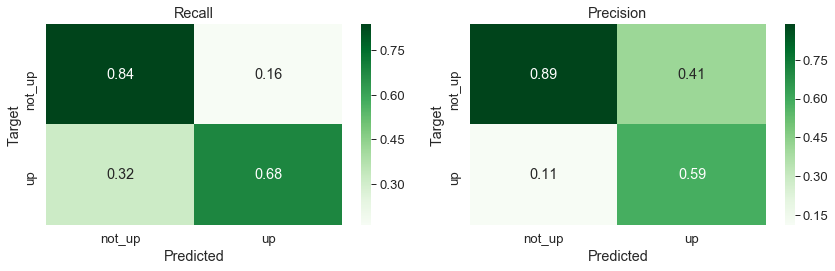

              precision    recall  f1-score   support

           0       0.89      0.84      0.86       181
           1       0.59      0.68      0.63        60

    accuracy                           0.80       241
   macro avg       0.74      0.76      0.75       241
weighted avg       0.81      0.80      0.81       241



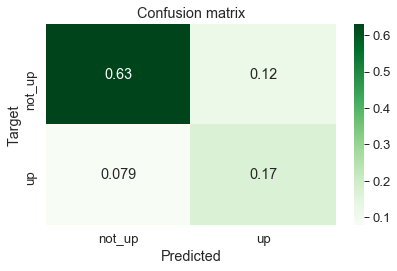

In [45]:
#confusion matrix for uptrend model
plot_cm(df.TARGET_buy[train_size:], df.lstm_up[train_size:], 
        ticklabels=['not_up','up'], cmap = 'Greens', figsize = (12,4), save_pref = '_up')

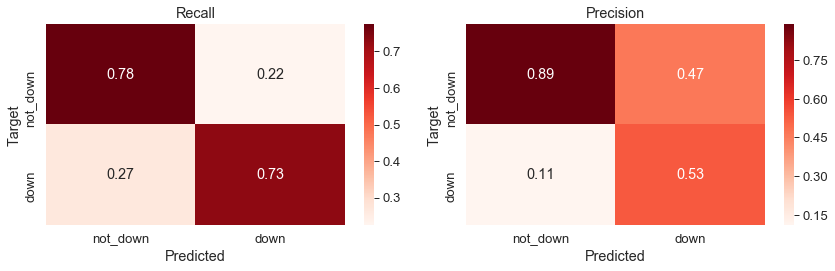

              precision    recall  f1-score   support

           0       0.89      0.78      0.83       178
           1       0.53      0.73      0.62        63

    accuracy                           0.76       241
   macro avg       0.71      0.75      0.72       241
weighted avg       0.80      0.76      0.77       241



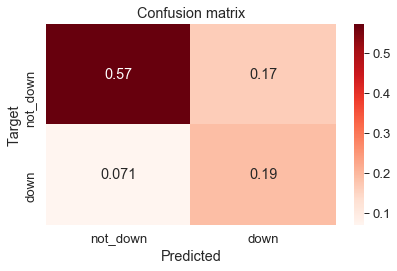

In [46]:
#confusion matrix for downtrend model
plot_cm(df.TARGET_sell[train_size:], df.lstm_down[train_size:], 
        ticklabels=['not_down','down'], cmap = 'Reds', figsize = (12,4), 
        save_pref = '_down')

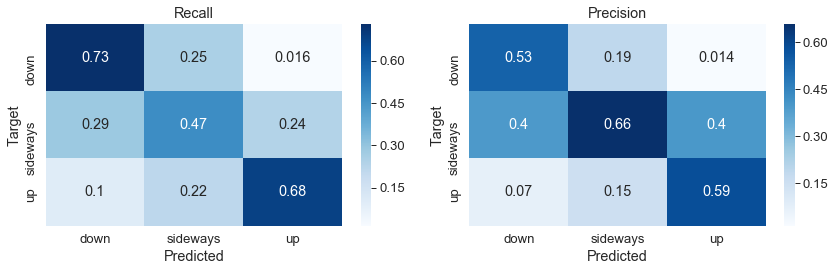

              precision    recall  f1-score   support

          -1       0.53      0.73      0.62        63
           0       0.66      0.47      0.55       118
           1       0.59      0.68      0.63        60

    accuracy                           0.59       241
   macro avg       0.59      0.63      0.60       241
weighted avg       0.61      0.59      0.59       241



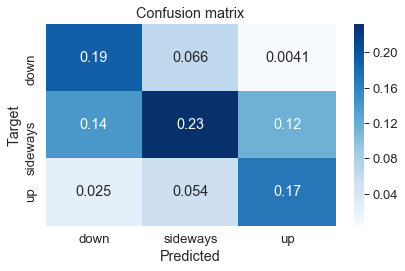

In [47]:
#confusion matrix for overall trend prediction (uptrend and downtrend combined)
plot_cm(df.TARGET_trend[train_size:], df.lstm_trend[train_size:], 
        ticklabels=['down','sideways','up'],
        cmap = 'Blues',figsize = (12,4), save_pref = '')

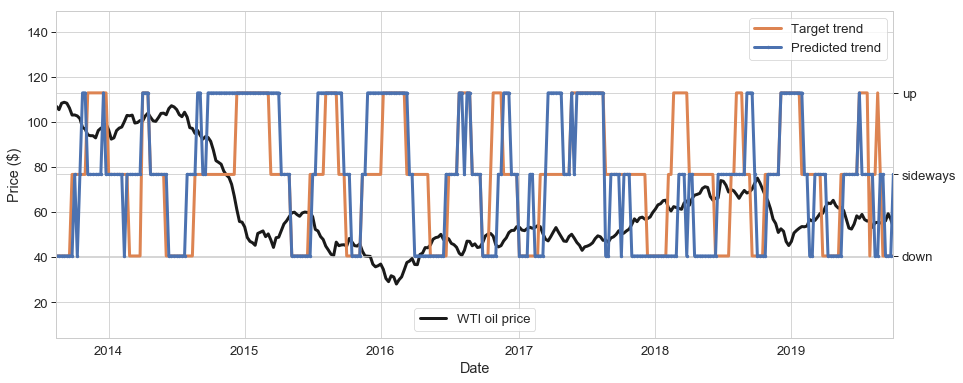

In [48]:
#visualize trends: target and predicted
start_date = end_train_date 
#start_date = pd.to_datetime('2019-01-01')
fig, ax = plt.subplots(1,1,figsize=(15,6))

#plot actual data
df.Close.plot(color='k', ax = ax, lw=3, label = "WTI oil price")
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_xlim(start_date, df.index[-1])
ax.legend(loc='lower center')

ax2 = ax.twinx()
df.TARGET_trend.plot(lw=3, ax=ax2,color=sns.color_palette()[1])
df.lstm_trend.plot(lw=3, marker='.', ax=ax2,color=sns.color_palette()[0])

ax2.set_xlim(start_date, df.index[-1])
ax2.set_ylim(-2,2)
ax2.set_yticks([-1,0,1])
ax2.set_yticklabels(['down','sideways','up'])
ax2.legend(('Target trend','Predicted trend'))
plt.show()

path = 'LSTM_trained_class/figs'
fig.savefig(f'{path}/trend_predictions.png')

In [49]:
#################################
###########assessment############
################################# 

#get value for buy/sell at extremums
df['Date'] = df.index
df_input = df.iloc[train_size:,:]
buy_list = df_min.index[df_min.index >= df.index[train_size]].tolist()
sell_list = df_max.index[df_max.index >= df.index[train_size]].tolist()

df_value = get_value(df_input,buy_list,sell_list)

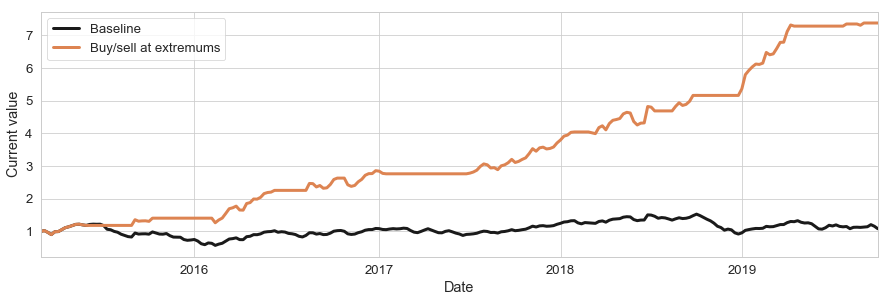

In [50]:
#plot
fig = plt.figure(figsize=(15,4.5))
(df_value['Baseline'] / df_value['Baseline'][0]).plot(lw=3, color = 'k')
(df_value['Value'] / df_value['Baseline'][0]).plot(lw=3, color = sns.color_palette()[1])
plt.legend(('Baseline','Buy/sell at extremums'))
plt.ylabel('Current value')
plt.show()

In [51]:
#get value for buy/sell at initial predicted uptrend(buy)/downtrend(sell) signals
df_input = df.iloc[train_size:,:]

buy_list = df_input[df_input.lstm_up == 1].index.tolist()
sell_list = df_input[df_input.lstm_down == 1].index.tolist()
df_value_lstm = get_value(df_input,buy_list,sell_list)

buy_list = df_input[df_input.TARGET_buy == 1].index.tolist()
sell_list = df_input[df_input.TARGET_sell == 1].index.tolist()
df_value_target = get_value(df_input,buy_list,sell_list)

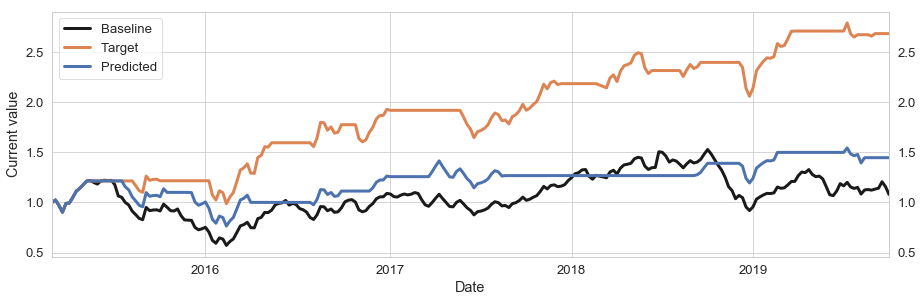

In [52]:
#plot model predictions assesment
fig = plt.figure(figsize=(15,4.5))

ref = df_value_lstm['Baseline'][0]
(df_value_lstm['Baseline'] / ref).plot(lw=3, color='k')
(df_value_target['Value'] / ref).plot(lw=3,color=sns.color_palette()[1])
(df_value_lstm['Value'] / ref).plot(lw=3,color=sns.color_palette()[0])

#(df_value_target_shift['Value'] / ref).plot(lw=3,color=sns.color_palette()[8])

plt.legend(('Baseline','Target','Predicted', 'Target shifted'))
plt.ylabel('Current value')
plt.tick_params(labelright=True)

plt.show()

path = 'LSTM_trained_class/figs'
fig.savefig(f'{path}/assessment.png')

In [28]:
###interactive plot
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

iplot([go.Scatter(
        x=df.index,
        y=df.Close,
        name='Price'),
      go.Scatter(
         x=df.index,
         y=(60 + df.TARGET_trend*30),
         name='Target trend'),
     go.Scatter(
         x=df.index,
         y=(60 + df.lstm_trend*30),
         name='Predicted trend'
         )
      ])